In [1]:
import pandas as pd
import niio
import nibabel as nb
import numpy as np

import fragmenter as frag

from congrads import conmap
import connectopy as topy

import h5py

In [2]:
label_file = '/mnt/parcellator/parcellation/parcellearning/Data/Labels/Desikan/285345.L.aparc.32k_fs_LR.label.gii'
R = frag.RegionExtractor.Extractor(label_file)
regions = R.map_regions()

In [3]:
rest_file = '/mnt/parcellator/parcellation/parcellearning/Data/RestingState/285345.rfMRI_Z-Trans_merged_CORTEX_LEFT.mat'
rest = niio.loaded.load(rest_file)

In [4]:
pre_file = '/mnt/parcellator/parcellation/parcellearning/Data/Connectopy/Regional/285345/precentral/285345.L.precentral.2.brain.Evecs.func.gii'
pre = niio.loaded.load(pre_file)
pre_inds = R.indices(regions, ['precentral'])

post_file = '/mnt/parcellator/parcellation/parcellearning/Data/Connectopy/Regional/285345/postcentral/285345.L.postcentral.2.brain.Evecs.func.gii'
post = niio.loaded.load(post_file)
post_inds = R.indices(regions, ['postcentral'])

In [5]:
mapping = topy.similarity_mapping.cross_similarity(rest[pre_inds, :], rest[post_inds, :], k = 50)

In [6]:
statY = topy.similarity_mapping.cross_mapping(post[post_inds, 0], mapping, statistic='mean')

In [7]:
A = topy.affine.OLS_MV(include_intercept=True)
A.fit(pre[pre_inds, 0], statY)

In [23]:
params = {'global': 
              {'id': '285345', 'x_path': pre_file, 'y_path': post_file},
         'model': 
              {'lin_dim': 1, 'neighbors': 50, 'atlas': 'Desikan'}}

In [25]:
topy.write.save_model(A, '/mnt/home/keschenb/Desktop/TestSaveModel.h5', params)

# Models: m_3


In [10]:
from scipy import stats

def top2circ(p):
    
    """
    Return area of circle with same perimeter as arbitrary shape.
    
    Parameters:
    - - - - -
    p: float
        perimeter of arbitary shape
    
    Returns:
    - - - -
    a: float
        area of circle
    r: float
        radius of circle
    """
    
    radius = p / (2*np.pi)
    area = np.pi*(radius**2)
    
    return [radius, area]

def skew(coordinates, neighbors):
    
    """
    Return skew of coordinate axis.
    
    Parameters:
    - - - - -
    coordinates: float, array
        features to compute skew of
    neighbors: int, array
        points to include in skew computation
    
    Returns:
    - - - -
    s: float, array
        skew value for each input point
    """
    
    coordinates = coordinates[neighbors]
    s = stats.skew(coordinates, axis=1)
    
    return s

def kurtosis(coordinates, neighbors):
    
    """
    Compute kutosis of coorinate axis.
    
    Parameters:
    - - - - -
    coordinates: float, array
        features to compute kurtosis of
    neighbors: int, array
        points in include in kurtosis computation
    
    Returns:
    - - - -
    k: float, array
        kurtosis value for each input point
    """
    
    coordinates = coordinates[neighbors]
    k = stats.kurtosis(coordinates, axis=1)
    
    return k

In [32]:
z = np.zeros((32492, 50))
y = np.zeros((32492, 50))
var = np.zeros((32492, 50))
med = np.zeros((32492, 50))
for k in np.arange(1, 51):
    
    K = kurtosis(post[:, 0], post_inds[mapping][:, 0:k])
    S = skew(post[:, 0], post_inds[mapping][:, 0:k])
    
    z[pre_inds, k-1] = K
    y[pre_inds, k-1] = S
    var[pre_inds, k-1] = post[:, 0][post_inds[mapping[:, 0:k]]].var(1)
    med[pre_inds, k-1] = np.median(post[:, 0][post_inds[mapping[:, 0:k]]], axis=1)
    
# niio.write.save(z, '/mnt/home/keschenb/Desktop/TestKurtosis.func.gii', 'CortexLeft')
# niio.write.save(y, '/mnt/home/keschenb/Desktop/TestSkew.func.gii', 'CortexLeft')
# niio.write.save(var, '/mnt/home/keschenb/Desktop/TestVariance.func.gii', 'CortexLeft')
niio.write.save(med.var(1), '/mnt/home/keschenb/Desktop/TestMedianVariance.func.gii', 'CortexLeft')

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

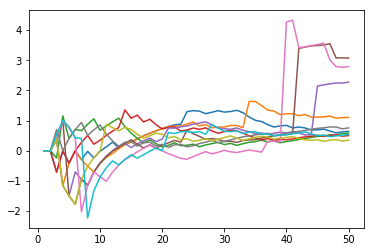

In [49]:
for k in pre_inds[990:1000]:
    plt.plot(np.arange(1,51), y[k, :])

/mnt/home/keschenb/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/mnt/home/keschenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice


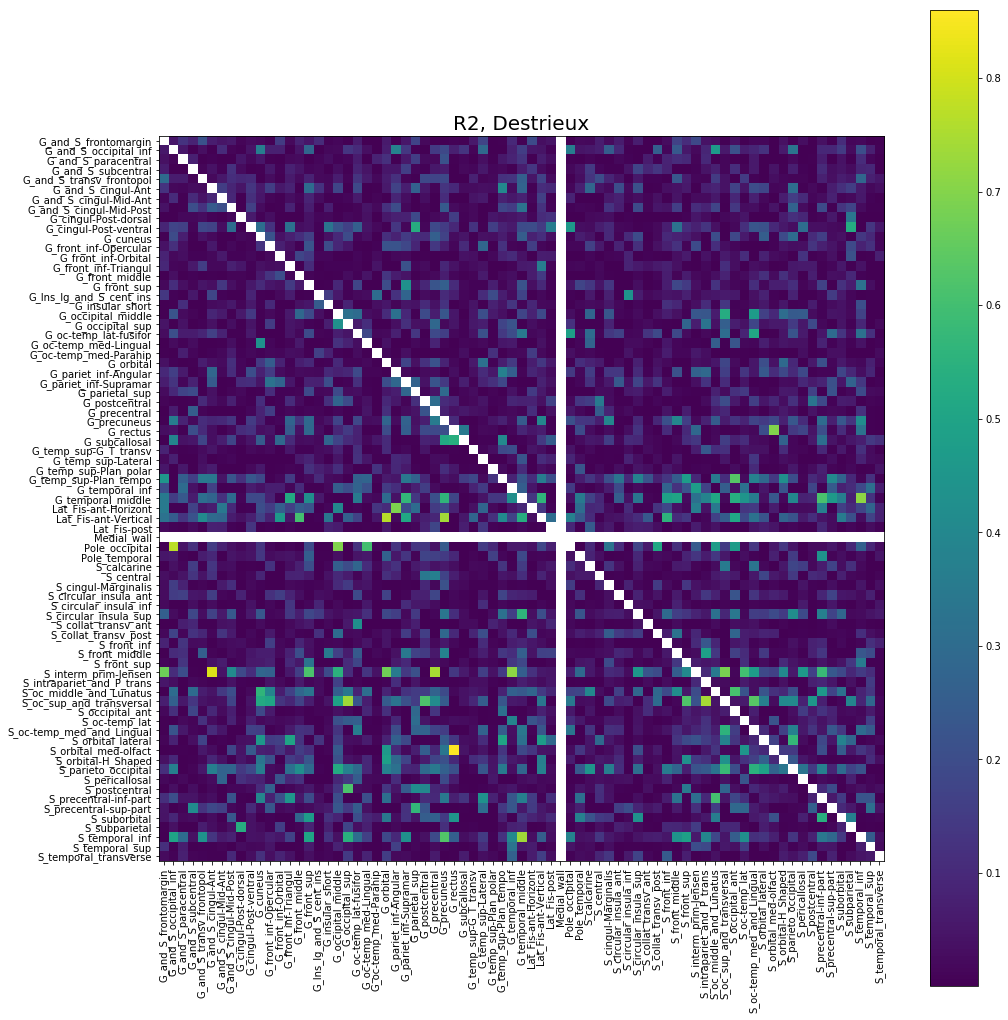

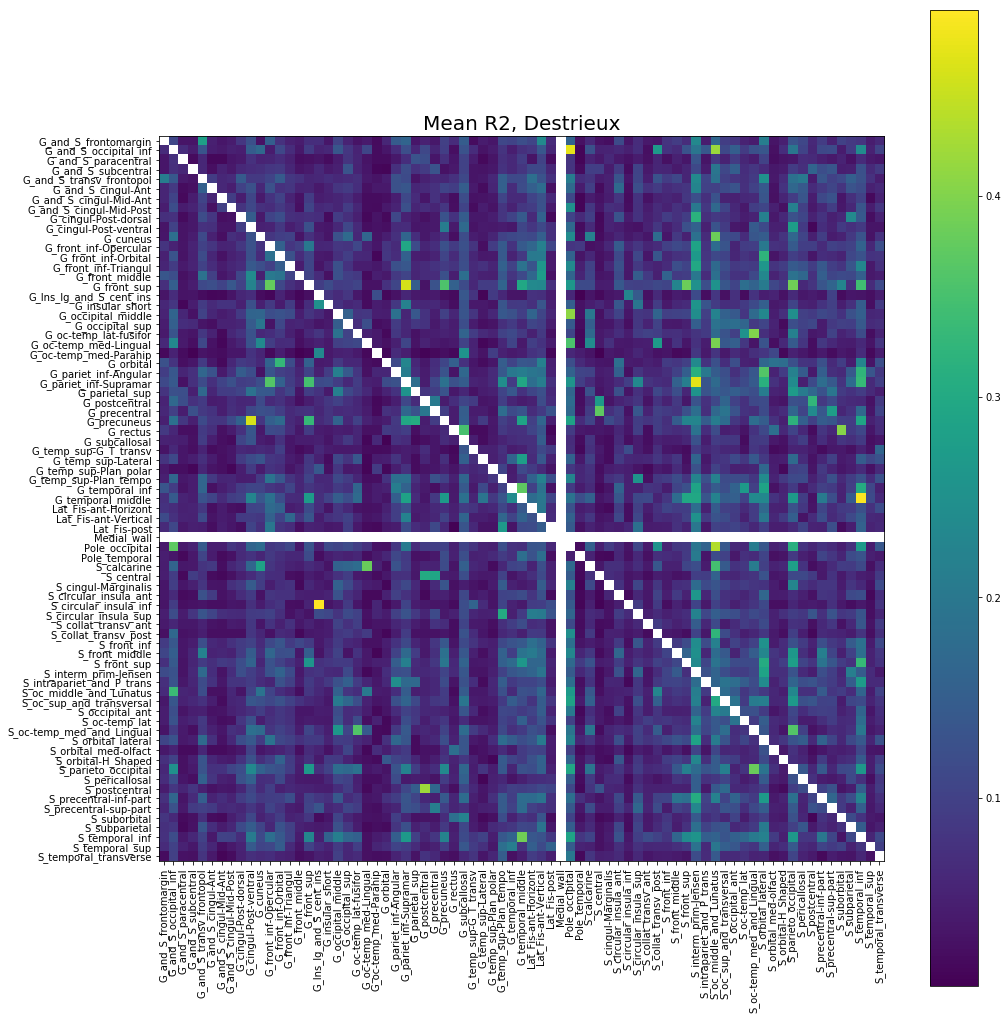

In [152]:
R = []
for subj in subjects:
    inr2 = '/mnt/parcellator/parcellation/parcellearning/Data/Connectopy/Regional/{:}/R2.L.Destrieux.mean.n5.d1.R2.mat'.format(subj)
    if os.path.exists(inr2):
        r2 = loaded.load(inr2)
        r2[np.diag_indices(n=r2.shape[0])] = np.nan
        R.append(r2[:,:,None])
        
        if subj == '285345':
            fig = plt.figure(figsize=(15, 15))
            plt.imshow(r2); plt.colorbar()
            plt.title('R2, Destrieux', fontsize=20)
            plt.yticks(np.arange(75), dest_regions, fontsize=10)
            plt.xticks(np.arange(75), dest_regions, fontsize=10, rotation='vertical')
            plt.tight_layout()
            plt.savefig('/mnt/parcellator/parcellation/285345.Destrieux.R2.jpg')

R = np.stack(R,axis=2).squeeze()

std_R = np.nanstd(R, axis=2)
mu_R = np.nanmean(R, axis=2)

F = write.adjacency_2_func(dest_region_map, mu_R.T, 32492)
write.save(F, '/mnt/parcellator/parcellation/Destrieux.Mean.R2.func.gii','CortexLeft')
fig = plt.figure(figsize=(15, 15))
plt.imshow(mu_R.T); plt.colorbar()
plt.title('Mean R2, Destrieux', fontsize=20)
plt.yticks(np.arange(75), dest_regions, fontsize=10)
plt.xticks(np.arange(75), dest_regions, fontsize=10, rotation='vertical')
plt.tight_layout()
plt.savefig('/mnt/parcellator/parcellation/Mean.Destrieux.R2.jpg')